In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

# visualization, graph
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(style='white', context='notebook', palette='deep', font_scale=1.5)

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir('/kaggle/input/competitive-data-science-predict-future-sales/'))

from glob import glob
from copy import deepcopy
import random
import pickle

['test.csv', 'item_categories.csv', 'shops.csv', 'items.csv', 'sales_train.csv', 'sample_submission.csv']


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost
from xgboost import XGBRegressor
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
import lightgbm
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, SelectPercentile, SelectKBest, f_regression
from sklearn import metrics 
from sklearn.metrics import mean_squared_error


### Files
* sales_train.csv - the training set. **Daily historical data from January 2013 to October 2015**.
* test.csv - the test set. You need to **forecast the sales for these shops and products for November 2015**.
* items.csv - supplemental information about **the items/products**.
* item_categories.csv  - supplemental information about **the items categories**.
* shops.csv- supplemental information about **the shops**.

### DATA
* ID - an Id that **represents a (Shop, Item) tuple within the test set**
* shop_id - unique identifier of a shop
* **item_id - unique identifier of a product**
* item_category_id - unique identifier of item category
* **item_cnt_day - number of products sold. You are predicting a monthly amount of this measure**
* **item_price - current price of an item**
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. **January 2013 is 0, February 2013 is 1,..., October 2015 is 33**
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

# Data Preprocessing

In [3]:
train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
sub = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_ca_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')

* add category feature, remove outlier,....

In [4]:
# add item_category_id 
train_df = pd.merge(train_df, items_df, on='item_id', how='left')
del train_df['item_name']
train_df = train_df[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

test_df = pd.merge(test_df, items_df, on='item_id', how='left')
del test_df['item_name']
del test_df['ID']
test_df = test_df[['shop_id', 'item_category_id', 'item_id']]

# date -> year, month, day
tmp = pd.DataFrame()
tmp['year'] = train_df['date'].agg(lambda x: int(x.split('.')[2]))
tmp['month'] = train_df['date'].agg(lambda x: int(x.split('.')[1]))
tmp['day'] = train_df['date'].agg(lambda x: int(x.split('.')[0]))

train_df2 = pd.concat([tmp, train_df], axis=1)
del train_df2['date']

test_df['year'] = 2015
test_df['month'] = 11
test_df['date_block_num'] = max(train_df2['date_block_num'])+1
test_df = test_df[['year', 'month', 'date_block_num', 'shop_id', 'item_category_id', 'item_id']]

# train set outlier check
train_df2.drop(train_df2[train_df2['item_cnt_day'] > 800].index, inplace=True)
train_df2.drop(train_df2[train_df2['item_cnt_day'] < 0].index, inplace=True)

train_df2.drop(train_df2[train_df2['item_price'] > 100000].index, inplace=True)
train_df2.drop(train_df2[train_df2['item_price'] < 0].index, inplace=True)

# check duplicates
train_df2 = train_df2.drop_duplicates(['year', 'month', 'day','date_block_num', 'shop_id', 'item_category_id','item_id', 'item_price', 'item_cnt_day'], keep='first')

# train set item cnt month sum
train_df3 = pd.DataFrame(train_df2.groupby(['shop_id','item_category_id','item_id','item_price','year','month','date_block_num'])['item_cnt_day'].sum())
train_df3.reset_index(inplace=True)
train_df3.columns = ['shop_id', 'item_category_id', 'item_id', 'item_price', 
                     'year', 'month', 'date_block_num','item_cnt']
train_df3 = train_df3[['year', 'month', 'date_block_num', 'shop_id', 'item_category_id', 'item_id','item_price','item_cnt']]

# train set monthly item cnt cliping
# train_df3.drop(train_df3[train_df3['item_cnt'] > 1000].index, inplace=True)
train_df3['item_cnt'] = train_df3['item_cnt'].clip(0,20)

train_df3.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'item cnt monthly probability plot')

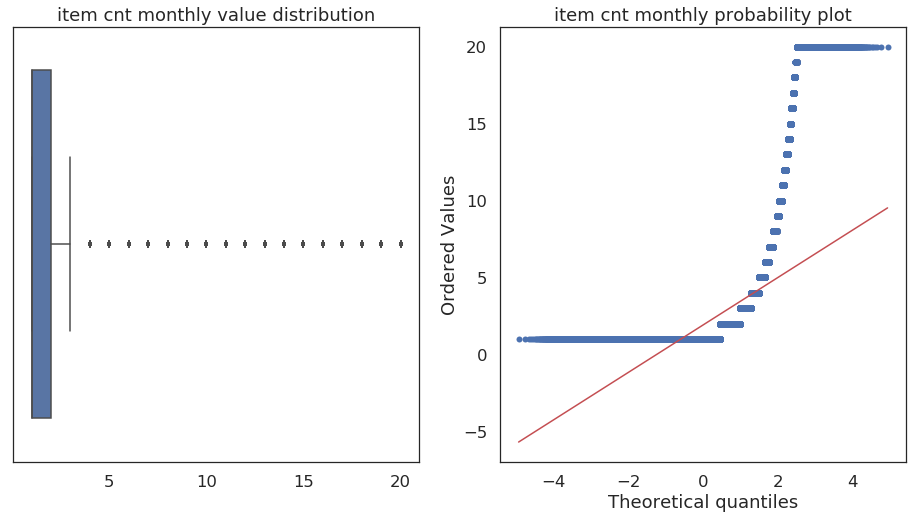

In [5]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df3['item_cnt'].values, ax=ax[0])
ax[0].set_title('item cnt monthly value distribution')
stats.probplot(train_df3['item_cnt'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item cnt monthly probability plot')

Text(0.5, 1.0, 'item price probability plot')

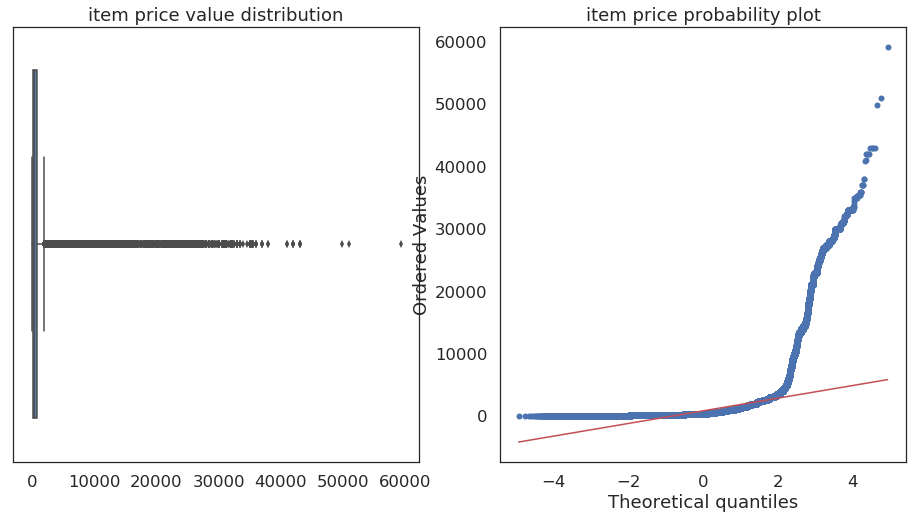

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(train_df3['item_price'].values, ax=ax[0])
ax[0].set_title('item price value distribution')
stats.probplot(train_df3['item_price'].values, dist='norm', fit=True, plot=ax[1])
ax[1].set_title('item price probability plot')

In [7]:
train_df3.head()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt
0,2013,2,1,0,0,16255,93.0,1.0
1,2013,2,1,0,1,5740,283.0,1.0
2,2013,2,1,0,2,5570,93.0,1.0
3,2013,1,0,0,2,5572,1322.0,10.0
4,2013,2,1,0,2,5572,1322.0,11.0


In [8]:
train_df3.isnull().sum()

year                0
month               0
date_block_num      0
shop_id             0
item_category_id    0
item_id             0
item_price          0
item_cnt            0
dtype: int64

In [9]:
test_df.head()

,year,month,date_block_num,shop_id,item_category_id,item_id
0,2015,11,34,5,19,5037
1,2015,11,34,5,55,5320
2,2015,11,34,5,19,5233
3,2015,11,34,5,23,5232
4,2015,11,34,5,20,5268


In [10]:
test_df.isnull().sum()

year                0
month               0
date_block_num      0
shop_id             0
item_category_id    0
item_id             0
dtype: int64

In [11]:
train_df3['year'] = train_df3['year'].astype(np.int32)
train_df3['month'] = train_df3['month'].astype(np.int32)
train_df3['date_block_num'] = train_df3['date_block_num'].astype(np.int32)
train_df3['shop_id'] = train_df3['shop_id'].astype(np.int32)
train_df3['item_id'] = train_df3['item_id'].astype(np.int32)
train_df3['item_category_id'] = train_df3['item_category_id'].astype(np.int32)
train_df3['item_cnt'] = train_df3['item_cnt'].astype(np.float16)

test_df['year'] = test_df['year'].astype(np.int32)
test_df['month'] = test_df['month'].astype(np.int32)
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int32)
test_df['shop_id'] = test_df['shop_id'].astype(np.int32)
test_df['item_id'] = test_df['item_id'].astype(np.int32)
test_df['item_category_id'] = test_df['item_category_id'].astype(np.int32)

In [12]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737862 entries, 0 to 1737861
Data columns (total 8 columns):
year                int32
month               int32
date_block_num      int32
shop_id             int32
item_category_id    int32
item_id             int32
item_price          float64
item_cnt            float16
dtypes: float16(1), float64(1), int32(6)
memory usage: 56.4 MB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 6 columns):
year                214200 non-null int32
month               214200 non-null int32
date_block_num      214200 non-null int32
shop_id             214200 non-null int32
item_category_id    214200 non-null int32
item_id             214200 non-null int32
dtypes: int32(6)
memory usage: 6.5 MB


* generating test set item price using train set price data

In [14]:
tmp = pd.merge(test_df, train_df3.iloc[:,:-1], on=['shop_id','item_category_id','item_id'], how='left', left_index=True, right_index=True)
test_df['item_price'] = tmp['item_price']

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 7 columns):
year                214200 non-null int32
month               214200 non-null int32
date_block_num      214200 non-null int32
shop_id             214200 non-null int32
item_category_id    214200 non-null int32
item_id             214200 non-null int32
item_price          214200 non-null float64
dtypes: float64(1), int32(6)
memory usage: 18.2 MB


# Feature Engineering

In [16]:
train_idx = train_df3.index
test_idx = list(range(len(train_df3), len(train_df3)+len(test_df)))

tmp = deepcopy(train_df3)
label = tmp.pop('item_cnt')

all_df = pd.concat([tmp, test_df], axis=0)
all_df.reset_index(drop=True, inplace=True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952062 entries, 0 to 1952061
Data columns (total 7 columns):
year                int32
month               int32
date_block_num      int32
shop_id             int32
item_category_id    int32
item_id             int32
item_price          float64
dtypes: float64(1), int32(6)
memory usage: 59.6 MB


In [17]:
all_df.head()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price
0,2013,2,1,0,0,16255,93.0
1,2013,2,1,0,1,5740,283.0
2,2013,2,1,0,2,5570,93.0
3,2013,1,0,0,2,5572,1322.0
4,2013,2,1,0,2,5572,1322.0


In [18]:
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price
1952057,2015,11,34,45,55,18454,359.0
1952058,2015,11,34,45,64,16188,149.0
1952059,2015,11,34,45,55,15757,149.0
1952060,2015,11,34,45,40,19648,149.0
1952061,2015,11,34,45,37,969,199.0


## feature1: item price 

* item price log

In [19]:
all_df['item_price_log'] = all_df['item_price'].map(lambda i: np.log(i) if i>0 else 0)

* item price mean, median groupby shop, groupby category

In [20]:
shop_mean_df = all_df.groupby('shop_id')['item_price'].agg({'mean','median'}).reset_index()
shop_mean_df.columns = ['shop_id', 'item_price_shopmean', 'item_price_shopmedian']
all_df = pd.merge(all_df, shop_mean_df, on=['shop_id'], how='left', right_index=True)

cat_mean_df = all_df.groupby('item_category_id')['item_price'].agg({'mean','median'}).reset_index()
cat_mean_df.columns = ['item_category_id', 'item_price_catmean','item_price_catmedian']
all_df = pd.merge(all_df, cat_mean_df, on=['item_category_id'], how='left', right_index=True)
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_shopmedian,item_price_catmean,item_price_catmedian
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,839.635422,299.0,344.303126
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,839.635422,799.0,1059.213638
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,839.635422,299.0,344.303126
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,839.635422,149.0,284.040483
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,839.635422,299.0,448.266365


* item price std groupby shop/item, groupby category/item

In [21]:
itemsh_trend_df = all_df.groupby(['year','shop_id','item_id'])['item_price'].std().reset_index()
itemsh_trend_df.columns = ['year', 'shop_id', 'item_id', 'item_price_std_in_sh']
itemsh_trend_df.fillna(0, inplace=True)
all_df = pd.merge(all_df, itemsh_trend_df, on=['year', 'shop_id', 'item_id'], how='left')

itemca_trend_df = all_df.groupby(['year','item_category_id','item_id'])['item_price'].std().reset_index()
itemca_trend_df.columns = ['year', 'item_category_id', 'item_id', 'item_price_std_in_ca']
itemca_trend_df.fillna(0, inplace=True)
all_df = pd.merge(all_df, itemca_trend_df, on=['year', 'item_category_id', 'item_id'], how='left')
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_shopmedian,item_price_catmean,item_price_catmedian,item_price_std_in_sh,item_price_std_in_ca
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,839.635422,299.0,344.303126,93.380940,451.004451
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,839.635422,799.0,1059.213638,0.000000,797.248194
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,839.635422,299.0,344.303126,28.867513,563.291232
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,839.635422,149.0,284.040483,0.000000,1038.267128
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,839.635422,299.0,448.266365,0.000000,1064.470404


Text(0.5, 0, 'price val')

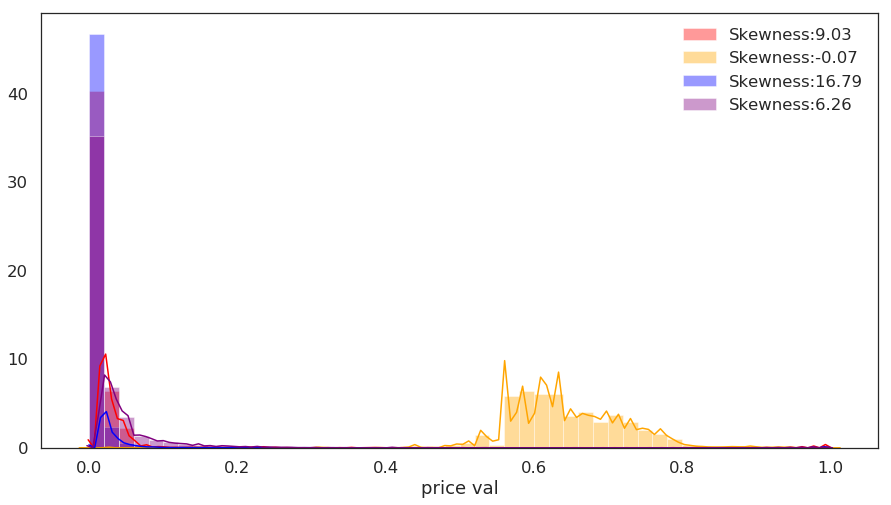

In [22]:
tmp = all_df.iloc[:,6:]
scaler = MinMaxScaler()
tmp[['item_price','item_price_log','item_price_std_in_sh','item_price_std_in_ca']] = scaler.fit_transform(tmp[['item_price','item_price_log','item_price_std_in_sh','item_price_std_in_ca']])

_, ax = plt.subplots(1,1,figsize=(15,8))
sns.distplot(tmp['item_price'], color='red', kde=True, ax=ax)
sns.distplot(tmp['item_price_log'], color='orange', kde=True, ax=ax)
sns.distplot(tmp['item_price_std_in_sh'], color='blue', kde=True, ax=ax)
sns.distplot(tmp['item_price_std_in_ca'], color='purple', kde=True, ax=ax)
plt.legend(['Skewness:{:.2f}'.format(tmp['item_price'].skew()),
           'Skewness:{:.2f}'.format(tmp['item_price_log'].skew()),
           'Skewness:{:.2f}'.format(tmp['item_price_std_in_sh'].skew()),
           'Skewness:{:.2f}'.format(tmp['item_price_std_in_ca'].skew())], loc='best')
plt.xlabel('price val')

* 같은 아이템이더라도 가게에 따라서, 카테고리에 따라서 가격이 상이해짐.
* 해당 아이템이 shop에서 저렴한 편인지, 중간가격, 비싼가격

In [23]:
all_df['isMinPrice_shop'] = np.where((all_df['item_price'] <= all_df['item_price_shopmean']) & (all_df['item_price'] <= all_df['item_price_shopmedian']), 1, 0)
all_df['isMaxPrice_shop'] = np.where((all_df['item_price'] > all_df['item_price_shopmean']) & (all_df['item_price'] > all_df['item_price_shopmedian']), 1, 0)
all_df['isMedianPrice_shop'] = np.where((all_df['isMinPrice_shop'] == 0) & (all_df['isMaxPrice_shop'] == 0), 1, 0)
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_shopmedian,item_price_catmean,item_price_catmedian,item_price_std_in_sh,item_price_std_in_ca,isMinPrice_shop,isMaxPrice_shop,isMedianPrice_shop
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,839.635422,299.0,344.303126,93.380940,451.004451,1,0,0
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,839.635422,799.0,1059.213638,0.000000,797.248194,1,0,0
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,839.635422,299.0,344.303126,28.867513,563.291232,1,0,0
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,839.635422,149.0,284.040483,0.000000,1038.267128,1,0,0
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,839.635422,299.0,448.266365,0.000000,1064.470404,1,0,0


* 해당 아이템이 category에서 저렴한 편인지, 중간가격, 비싼가격

In [24]:
all_df['isMinPrice_cat'] = np.where((all_df['item_price'] <= all_df['item_price_catmean']) & (all_df['item_price'] <= all_df['item_price_catmedian']), 1, 0)
all_df['isMaxPrice_cat'] = np.where((all_df['item_price'] > all_df['item_price_catmean']) & (all_df['item_price'] > all_df['item_price_catmedian']), 1, 0)
all_df['isMedianPrice_cat'] = np.where((all_df['isMinPrice_cat'] == 0) & (all_df['isMaxPrice_cat'] == 0), 1, 0)
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_shopmedian,item_price_catmean,item_price_catmedian,item_price_std_in_sh,item_price_std_in_ca,isMinPrice_shop,isMaxPrice_shop,isMedianPrice_shop,isMinPrice_cat,isMaxPrice_cat,isMedianPrice_cat
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,839.635422,299.0,344.303126,93.380940,451.004451,1,0,0,0,1,0
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,839.635422,799.0,1059.213638,0.000000,797.248194,1,0,0,1,0,0
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,839.635422,299.0,344.303126,28.867513,563.291232,1,0,0,1,0,0
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,839.635422,149.0,284.040483,0.000000,1038.267128,1,0,0,1,0,0
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,839.635422,299.0,448.266365,0.000000,1064.470404,1,0,0,1,0,0


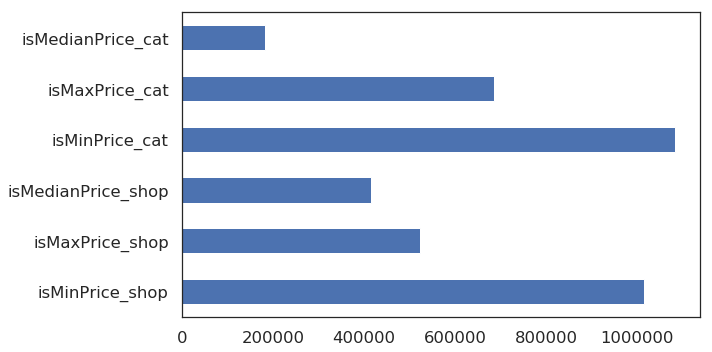

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
tmp = all_df.iloc[:,14:]
tmp.agg('sum').plot(kind='barh', ax=ax)
plt.tight_layout()

In [26]:
all_df['isMinPrice_shop'] = all_df['isMinPrice_shop'].astype(np.int8)
all_df['isMaxPrice_shop'] = all_df['isMaxPrice_shop'].astype(np.int8)
all_df['isMedianPrice_shop'] = all_df['isMedianPrice_shop'].astype(np.int8)
all_df['isMinPrice_cat'] = all_df['isMinPrice_cat'].astype(np.int8)
all_df['isMaxPrice_cat'] = all_df['isMaxPrice_cat'].astype(np.int8)
all_df['isMedianPrice_cat'] = all_df['isMedianPrice_cat'].astype(np.int8)
# del all_df['item_price_shopmean']
del all_df['item_price_shopmedian']
# del all_df['item_price_catmean']
del all_df['item_price_catmedian']

In [27]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952062 entries, 0 to 1952061
Data columns (total 18 columns):
year                    int32
month                   int32
date_block_num          int32
shop_id                 int32
item_category_id        int32
item_id                 int32
item_price              float64
item_price_log          float64
item_price_shopmean     float64
item_price_catmean      float64
item_price_std_in_sh    float64
item_price_std_in_ca    float64
isMinPrice_shop         int8
isMaxPrice_shop         int8
isMedianPrice_shop      int8
isMinPrice_cat          int8
isMaxPrice_cat          int8
isMedianPrice_cat       int8
dtypes: float64(6), int32(6), int8(6)
memory usage: 160.1 MB


In [28]:
tmp = all_df.copy()

In [29]:
# all_df = tmp

## feature2: item sales 

* shop 분기별 평균 판매량 (1분기: 1~3, 2분기: 4~6, 3분기: 7~9, 4분기: 10~12)

In [30]:
data_features = all_df[all_df.index.isin(train_idx)]
data_features['item_cnt'] = label
data_features.head()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,item_price_std_in_sh,item_price_std_in_ca,isMinPrice_shop,isMaxPrice_shop,isMedianPrice_shop,isMinPrice_cat,isMaxPrice_cat,isMedianPrice_cat,item_cnt
0,2013,2,1,0,0,16255,93.0,4.532599,200.0,399.0,0.0,0.000000,1,0,0,1,0,0,1.0
1,2013,2,1,0,1,5740,283.0,5.645447,200.0,215.5,0.0,0.000000,0,0,1,0,1,0,1.0
2,2013,2,1,0,2,5570,93.0,4.532599,200.0,2390.0,0.0,0.000000,1,0,0,1,0,0,1.0
3,2013,1,0,0,2,5572,1322.0,7.186901,200.0,2390.0,0.0,61.828015,0,1,0,1,0,0,10.0
4,2013,2,1,0,2,5572,1322.0,7.186901,200.0,2390.0,0.0,61.828015,0,1,0,1,0,0,11.0


In [31]:
qdf1 = data_features.loc[(data_features['month']==1) | (data_features['month']==2) | (data_features['month']==3)]
qdf2 = data_features.loc[(data_features['month']==4) | (data_features['month']==5) | (data_features['month']==6)]
qdf3 = data_features.loc[(data_features['month']==7) | (data_features['month']==8) | (data_features['month']==9)]
qdf4 = data_features.loc[(data_features['month']==10) | (data_features['month']==11) | (data_features['month']==12)]

In [32]:
def get_quarter_sales(group, colnames):
    global all_df
    qdf1_g = qdf1.groupby(group)['item_cnt'].mean().reset_index()
    name = deepcopy(group)
    name.append(colnames[0])
    qdf1_g.columns = name
    all_df = pd.merge(all_df, qdf1_g, on=group, how='left')

    qdf2_g = qdf2.groupby(group)['item_cnt'].mean().reset_index()
    name = deepcopy(group)
    name.append(colnames[1])
    qdf2_g.columns = name
    all_df = pd.merge(all_df, qdf2_g, on=group, how='left')

    qdf3_g = qdf3.groupby(group)['item_cnt'].mean().reset_index()
    name = deepcopy(group)
    name.append(colnames[2])
    qdf3_g.columns = name
    all_df = pd.merge(all_df, qdf3_g, on=group, how='left')

    qdf4_g = qdf4.groupby(group)['item_cnt'].mean().reset_index()
    name = deepcopy(group)
    name.append(colnames[3])
    qdf4_g.columns = name
    all_df = pd.merge(all_df, qdf4_g, on=group, how='left')

    quarters = [(all_df['month']==1) | (all_df['month']==2) | (all_df['month']==3),
                (all_df['month']==4) | (all_df['month']==5) | (all_df['month']==6),
                (all_df['month']==7) | (all_df['month']==8) | (all_df['month']==9),
                (all_df['month']==10) | (all_df['month']==11) | (all_df['month']==12)]
    
    all_df.loc[quarters[0], colnames[1]] = 0
    all_df.loc[quarters[0], colnames[2]] = 0
    all_df.loc[quarters[0], colnames[3]] = 0

    all_df.loc[quarters[1], colnames[0]] = 0
    all_df.loc[quarters[1], colnames[2]] = 0
    all_df.loc[quarters[1], colnames[3]] = 0

    all_df.loc[quarters[2], colnames[0]] = 0
    all_df.loc[quarters[2], colnames[1]] = 0
    all_df.loc[quarters[2], colnames[3]] = 0

    all_df.loc[quarters[3], colnames[0]] = 0
    all_df.loc[quarters[3], colnames[1]] = 0
    all_df.loc[quarters[3], colnames[2]] = 0
    
    # 채워지지 않은 값들(train set에서 test set의 item이 존재하지 않는 경우)은 해당 feature의 median으로 채움.
#     for i, feature in enumerate(colnames) :
#         vals = all_df.loc[quarters[i], feature].dropna()
#         all_df.loc[quarters[i], feature] = all_df.loc[quarters[i], feature].fillna(np.median(vals.astype(float)))
    all_df.fillna(0, inplace=True)
    
get_quarter_sales(['shop_id','year'], ['s_quarter1_item_cnt', 's_quarter2_item_cnt', 's_quarter3_item_cnt', 's_quarter4_item_cnt'])
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,isMinPrice_shop,isMaxPrice_shop,isMedianPrice_shop,isMinPrice_cat,isMaxPrice_cat,isMedianPrice_cat,s_quarter1_item_cnt,s_quarter2_item_cnt,s_quarter3_item_cnt,s_quarter4_item_cnt
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,299.0,...,1,0,0,0,1,0,0.0,0.0,0.0,1.433594
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,799.0,...,1,0,0,1,0,0,0.0,0.0,0.0,1.433594
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,299.0,...,1,0,0,1,0,0,0.0,0.0,0.0,1.433594
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,149.0,...,1,0,0,1,0,0,0.0,0.0,0.0,1.433594
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,299.0,...,1,0,0,1,0,0,0.0,0.0,0.0,1.433594


* item 분기별 평균 판매량 (1분기: 1~3, 2분기: 4~6, 3분기: 7~9, 4분기: 10~12)

In [33]:
get_quarter_sales(['item_id','year'], ['i_quarter1_item_cnt', 'i_quarter2_item_cnt', 'i_quarter3_item_cnt', 'i_quarter4_item_cnt'])
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,isMaxPrice_cat,isMedianPrice_cat,s_quarter1_item_cnt,s_quarter2_item_cnt,s_quarter3_item_cnt,s_quarter4_item_cnt,i_quarter1_item_cnt,i_quarter2_item_cnt,i_quarter3_item_cnt,i_quarter4_item_cnt
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,299.0,...,1,0,0.0,0.0,0.0,1.433594,0.0,0.0,0.0,1.0
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,799.0,...,0,0,0.0,0.0,0.0,1.433594,0.0,0.0,0.0,1.0
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,299.0,...,0,0,0.0,0.0,0.0,1.433594,0.0,0.0,0.0,1.0
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,149.0,...,0,0,0.0,0.0,0.0,1.433594,0.0,0.0,0.0,1.0
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,299.0,...,0,0,0.0,0.0,0.0,1.433594,0.0,0.0,0.0,1.0


* item category 분기별 평균 판매량 (1분기: 1~3, 2분기: 4~6, 3분기: 7~9, 4분기: 10~12)

In [34]:
get_quarter_sales(['item_category_id','year'], ['c_quarter1_item_cnt', 'c_quarter2_item_cnt', 'c_quarter3_item_cnt', 'c_quarter4_item_cnt'])
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,s_quarter3_item_cnt,s_quarter4_item_cnt,i_quarter1_item_cnt,i_quarter2_item_cnt,i_quarter3_item_cnt,i_quarter4_item_cnt,c_quarter1_item_cnt,c_quarter2_item_cnt,c_quarter3_item_cnt,c_quarter4_item_cnt
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,299.0,...,0.0,1.433594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.348633
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,799.0,...,0.0,1.433594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.326172
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,299.0,...,0.0,1.433594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.348633
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,149.0,...,0.0,1.433594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.586914
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,299.0,...,0.0,1.433594,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.627930


* shop/item 그룹 분기별 평균 판매량 (1분기: 1~3, 2분기: 4~6, 3분기: 7~9, 4분기: 10~12)

In [35]:
get_quarter_sales(['shop_id','item_id','year'], ['si_quarter1_item_cnt', 'si_quarter2_item_cnt', 'si_quarter3_item_cnt', 'si_quarter4_item_cnt'])
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,i_quarter3_item_cnt,i_quarter4_item_cnt,c_quarter1_item_cnt,c_quarter2_item_cnt,c_quarter3_item_cnt,c_quarter4_item_cnt,si_quarter1_item_cnt,si_quarter2_item_cnt,si_quarter3_item_cnt,si_quarter4_item_cnt
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,299.0,...,0.0,1.0,0.0,0.0,0.0,1.348633,0.0,0.0,0.0,1.0
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,799.0,...,0.0,1.0,0.0,0.0,0.0,1.326172,0.0,0.0,0.0,0.0
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,299.0,...,0.0,1.0,0.0,0.0,0.0,1.348633,0.0,0.0,0.0,0.0
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,149.0,...,0.0,1.0,0.0,0.0,0.0,1.586914,0.0,0.0,0.0,0.0
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,299.0,...,0.0,1.0,0.0,0.0,0.0,1.627930,0.0,0.0,0.0,0.0


* shop/item category 그룹 분기별 평균 판매량 (1분기: 1~3, 2분기: 4~6, 3분기: 7~9, 4분기: 10~12)

In [36]:
get_quarter_sales(['shop_id','item_category_id','year'], ['sc_quarter1_item_cnt', 'sc_quarter2_item_cnt', 'sc_quarter3_item_cnt', 'sc_quarter4_item_cnt'])
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,c_quarter3_item_cnt,c_quarter4_item_cnt,si_quarter1_item_cnt,si_quarter2_item_cnt,si_quarter3_item_cnt,si_quarter4_item_cnt,sc_quarter1_item_cnt,sc_quarter2_item_cnt,sc_quarter3_item_cnt,sc_quarter4_item_cnt
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,299.0,...,0.0,1.348633,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.197266
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,799.0,...,0.0,1.326172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,299.0,...,0.0,1.348633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.197266
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,149.0,...,0.0,1.586914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.269531
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,299.0,...,0.0,1.627930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.125000


* category/item 그룹 분기별 평균 판매량 (1분기: 1~3, 2분기: 4~6, 3분기: 7~9, 4분기: 10~12)

In [37]:
get_quarter_sales(['item_category_id','item_id','year'], ['ci_quarter1_item_cnt', 'ci_quarter2_item_cnt', 'ci_quarter3_item_cnt', 'ci_quarter4_item_cnt'])
all_df.tail()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,si_quarter3_item_cnt,si_quarter4_item_cnt,sc_quarter1_item_cnt,sc_quarter2_item_cnt,sc_quarter3_item_cnt,sc_quarter4_item_cnt,ci_quarter1_item_cnt,ci_quarter2_item_cnt,ci_quarter3_item_cnt,ci_quarter4_item_cnt
1952057,2015,11,34,45,55,18454,359.0,5.883322,399.0,299.0,...,0.0,1.0,0.0,0.0,0.0,1.197266,0.0,0.0,0.0,1.0
1952058,2015,11,34,45,64,16188,149.0,5.003946,399.0,799.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0
1952059,2015,11,34,45,55,15757,149.0,5.003946,399.0,299.0,...,0.0,0.0,0.0,0.0,0.0,1.197266,0.0,0.0,0.0,1.0
1952060,2015,11,34,45,40,19648,149.0,5.003946,399.0,149.0,...,0.0,0.0,0.0,0.0,0.0,1.269531,0.0,0.0,0.0,1.0
1952061,2015,11,34,45,37,969,199.0,5.293305,399.0,299.0,...,0.0,0.0,0.0,0.0,0.0,1.125000,0.0,0.0,0.0,1.0


In [38]:
all_df.head()

,year,month,date_block_num,shop_id,item_category_id,item_id,item_price,item_price_log,item_price_shopmean,item_price_catmean,...,si_quarter3_item_cnt,si_quarter4_item_cnt,sc_quarter1_item_cnt,sc_quarter2_item_cnt,sc_quarter3_item_cnt,sc_quarter4_item_cnt,ci_quarter1_item_cnt,ci_quarter2_item_cnt,ci_quarter3_item_cnt,ci_quarter4_item_cnt
0,2013,2,1,0,0,16255,93.0,4.532599,200.0,399.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
1,2013,2,1,0,1,5740,283.0,5.645447,200.0,215.5,...,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
2,2013,2,1,0,2,5570,93.0,4.532599,200.0,2390.0,...,0.0,0.0,2.763672,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3,2013,1,0,0,2,5572,1322.0,7.186901,200.0,2390.0,...,0.0,0.0,2.763672,0.0,0.0,0.0,3.203125,0.0,0.0,0.0
4,2013,2,1,0,2,5572,1322.0,7.186901,200.0,2390.0,...,0.0,0.0,2.763672,0.0,0.0,0.0,3.203125,0.0,0.0,0.0


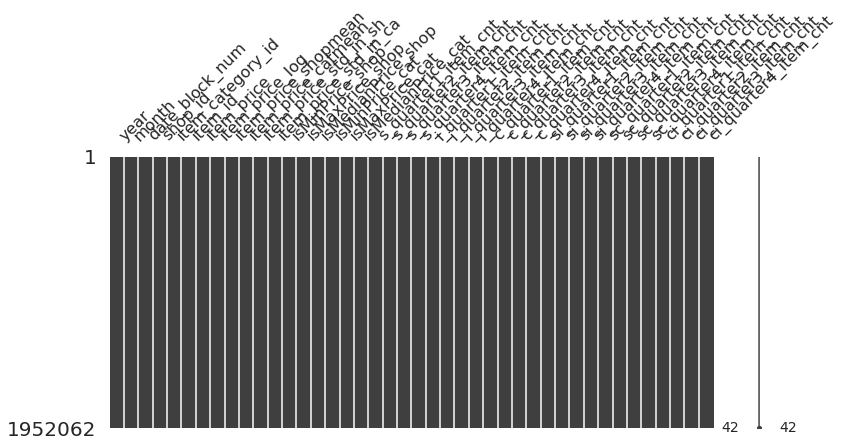

In [39]:
import missingno as msno

msno.matrix(all_df, figsize=(12,5))

# Modeling

In [40]:
all_df = all_df[['month',
#                 'year',
                'date_block_num', 
                'shop_id', 
#                 'item_category_id',
                'item_id', 
#                 'item_price', 
                'item_price_log', 
                'item_price_shopmean',
                'item_price_catmean', 
#                 'item_price_std_in_sh',
#                 'item_price_std_in_ca',
                'isMinPrice_shop', 'isMaxPrice_shop', 
                'isMedianPrice_shop','isMedianPrice_cat',
                'isMinPrice_cat', 'isMaxPrice_cat', 
                's_quarter1_item_cnt', 's_quarter2_item_cnt', 's_quarter3_item_cnt', 's_quarter4_item_cnt', 
                'i_quarter1_item_cnt', 'i_quarter2_item_cnt', 'i_quarter3_item_cnt', 'i_quarter4_item_cnt', 
                'c_quarter1_item_cnt', 'c_quarter2_item_cnt', 'c_quarter3_item_cnt', 'c_quarter4_item_cnt',
                'si_quarter1_item_cnt', 'si_quarter2_item_cnt', 'si_quarter3_item_cnt', 'si_quarter4_item_cnt', 
                'sc_quarter1_item_cnt', 'sc_quarter2_item_cnt', 'sc_quarter3_item_cnt', 'sc_quarter4_item_cnt', 
                'ci_quarter1_item_cnt', 'ci_quarter2_item_cnt', 'ci_quarter3_item_cnt', 'ci_quarter4_item_cnt']]

In [41]:
train_set = all_df[all_df.index.isin(train_idx)]
train_df3.shape, train_set.shape

((1737862, 8), (1737862, 37))

In [42]:
train_set['item_cnt'] = train_df3['item_cnt']
train_set.head(10)

,month,date_block_num,shop_id,item_id,item_price_log,item_price_shopmean,item_price_catmean,isMinPrice_shop,isMaxPrice_shop,isMedianPrice_shop,...,si_quarter4_item_cnt,sc_quarter1_item_cnt,sc_quarter2_item_cnt,sc_quarter3_item_cnt,sc_quarter4_item_cnt,ci_quarter1_item_cnt,ci_quarter2_item_cnt,ci_quarter3_item_cnt,ci_quarter4_item_cnt,item_cnt
0,2,1,0,16255,4.532599,200.0,399.0,1,0,0,...,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0
1,2,1,0,5740,5.645447,200.0,215.5,0,0,1,...,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0
2,2,1,0,5570,4.532599,200.0,2390.0,1,0,0,...,0.0,2.763672,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0
3,1,0,0,5572,7.186901,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,3.203125,0.0,0.0,0.0,10.0
4,2,1,0,5572,7.186901,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,3.203125,0.0,0.0,0.0,11.0
5,1,0,0,5573,6.327937,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,1.747070,0.0,0.0,0.0,1.0
6,2,1,0,5573,6.327937,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,1.747070,0.0,0.0,0.0,1.0
7,2,1,0,5574,6.327937,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,2.878906,0.0,0.0,0.0,3.0
8,1,0,0,5575,6.692084,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,1.956055,0.0,0.0,0.0,4.0
9,1,0,0,5576,7.710205,200.0,2390.0,0,1,0,...,0.0,2.763672,0.0,0.0,0.0,1.675781,0.0,0.0,0.0,5.0


In [43]:
test_set = all_df[all_df.index.isin(test_idx)]
test_set.shape

(214200, 37)

In [44]:
test_set.reset_index(drop=True, inplace=True)
test_set.head(10)

,month,date_block_num,shop_id,item_id,item_price_log,item_price_shopmean,item_price_catmean,isMinPrice_shop,isMaxPrice_shop,isMedianPrice_shop,...,si_quarter3_item_cnt,si_quarter4_item_cnt,sc_quarter1_item_cnt,sc_quarter2_item_cnt,sc_quarter3_item_cnt,sc_quarter4_item_cnt,ci_quarter1_item_cnt,ci_quarter2_item_cnt,ci_quarter3_item_cnt,ci_quarter4_item_cnt
0,11,34,5,5037,4.532599,399.0,1199.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.727539,0.0,0.0,0.0,1.470703
1,11,34,5,5320,5.645447,399.0,299.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.191406,0.0,0.0,0.0,0.000000
2,11,34,5,5233,4.532599,399.0,1199.0,1,0,0,...,0.0,1.0,0.0,0.0,0.0,1.727539,0.0,0.0,0.0,1.555664
3,11,34,5,5232,7.186901,399.0,1199.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.375000,0.0,0.0,0.0,1.526367
4,11,34,5,5268,7.186901,399.0,2499.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,2.902344,0.0,0.0,0.0,0.000000
5,11,34,5,5039,6.327937,399.0,1199.0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,1.375000,0.0,0.0,0.0,1.450195
6,11,34,5,5041,6.327937,399.0,2499.0,0,0,1,...,0.0,2.0,0.0,0.0,0.0,2.902344,0.0,0.0,0.0,2.250000
7,11,34,5,5046,6.327937,399.0,299.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.191406,0.0,0.0,0.0,1.090820
8,11,34,5,5319,6.692084,399.0,299.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.191406,0.0,0.0,0.0,1.529297
9,11,34,5,5003,7.710205,399.0,2499.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,2.902344,0.0,0.0,0.0,2.714844


## make train set, valid set, test set

In [45]:
X_train = train_set.loc[train_set['date_block_num'] < 33]
y_train = X_train['item_cnt']
del X_train['item_cnt']
X_valid = train_set.loc[train_set['date_block_num'] == 33]
y_valid = X_valid['item_cnt']
del X_valid['item_cnt']

X_test = test_set.copy()

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((1704677, 37), (33185, 37), (1704677,), (33185,), (214200, 37))

In [46]:
# scailing
cotinuous_features = ['item_price_shopmean','item_price_catmean'] #['item_price','item_price_shopmean','item_price_catmean','item_price_std_in_sh','item_price_std_in_ca']
count_features = ['s_quarter1_item_cnt', 's_quarter2_item_cnt', 's_quarter3_item_cnt', 's_quarter4_item_cnt',
                 'i_quarter1_item_cnt', 'i_quarter2_item_cnt', 'i_quarter3_item_cnt', 'i_quarter4_item_cnt',
                 'c_quarter1_item_cnt', 'c_quarter2_item_cnt', 'c_quarter3_item_cnt', 'c_quarter4_item_cnt',
                 'si_quarter1_item_cnt', 'si_quarter2_item_cnt', 'si_quarter3_item_cnt', 'si_quarter4_item_cnt',
                 'sc_quarter1_item_cnt', 'sc_quarter2_item_cnt', 'sc_quarter3_item_cnt', 'sc_quarter4_item_cnt',
                 'ci_quarter1_item_cnt', 'ci_quarter2_item_cnt', 'ci_quarter3_item_cnt', 'ci_quarter4_item_cnt']

scaler = StandardScaler()
X_train[cotinuous_features] = scaler.fit_transform(X_train[cotinuous_features])
X_valid[cotinuous_features] = scaler.transform(X_valid[cotinuous_features])
X_test[cotinuous_features] = scaler.transform(X_test[cotinuous_features])

scaler = MinMaxScaler()
X_train[count_features] = scaler.fit_transform(X_train[count_features])
X_valid[count_features] = scaler.transform(X_valid[count_features])
X_test[count_features] = scaler.transform(X_test[count_features])

## learning models LN, RF, XGB, LGBM, CATB,...

In [47]:
lnreg = LinearRegression(n_jobs=-1)

rfreg = RandomForestRegressor(max_depth=10, 
                              n_jobs=-1,
                              n_estimators=50,
                              bootstrap=True)

xgbreg = XGBRegressor(max_depth=8,
                      nthread=4, 
                      gamma=0.05,
#                       tree_method='gpu_exact',  
#                       min_child_weight=300,
                      colsample_bytree=0.8,
#                       subsample=0.8,
                      eta=0.1,
                      n_estimators=1000,
                      seed=42)

lgbreg = LGBMRegressor(n_jobs=-1,
                       max_depth=10,
                       num_leaves=(2^10)-1,
#                        min_child_weight=300,
                       learning_rate=0.05,
                       n_estimators=1000,
                       random_state=42)

catreg = CatBoostRegressor(thread_count=4,
#                            task_type='GPU',
#                            iterations=1000,
                           n_estimators=1000,
                           max_depth=10,
#                            max_ctr_complexity=4,
                           eta=0.1,
                           random_seed=42,
                           eval_metric='RMSE')

In [48]:
print('=======================LR======================')
lnreg.fit(X_train, y_train)

print('=======================RF======================')
rfreg.fit(X_train, y_train)

print('=======================XGB======================')
xgbreg.fit(X_train, y_train,
           eval_metric="rmse",
           eval_set=[(X_train, y_train), (X_valid, y_valid)],
           verbose=10,
           early_stopping_rounds = 10)

print('=======================LGBM======================')
feature_name = ['month','shop_id','item_id']

lgbreg.fit(X_train, y_train,
           eval_metric='rmse',
           categorical_feature = feature_name,
           eval_set=[(X_train, y_train), (X_valid, y_valid)],
           verbose=10, 
           early_stopping_rounds = 10)

print('=======================CATB======================')
catreg.fit(X_train, y_train.astype(float),
           cat_features=feature_name,
           eval_set=(X_valid, y_valid.astype(float)),
           verbose=50, 
           early_stopping_rounds = 50)

=======================LR======================
=======================RF======================
=======================XGB======================
[10:15:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.55361	validation_1-rmse:2.48549
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1.51314	validation_1-rmse:1.16412
[20]	validation_0-rmse:1.28113	validation_1-rmse:0.826225
[30]	validation_0-rmse:1.22213	validation_1-rmse:0.73051
[40]	validation_0-rmse:1.19536	validation_1-rmse:0.714283
[50]	validation_0-rmse:1.17498	validation_1-rmse:0.711646
[60]	validation_0-rmse:1.16016	validation_1-rmse:0.71175
Stopping. Best iteration:
[54]	validation_0-rmse:1.16912	validation_1-rmse:0.71066

=======================LGBM======================
Training until validation scores d

In [49]:
def get_rmse(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse)

print('LR RMSE: {:.3f}'.format(get_rmse(y_valid, lnreg.predict(X_valid))))
print('RF RMSE: {:.3f}'.format(get_rmse(y_valid, rfreg.predict(X_valid))))
print('XGB RMSE: {:.3f}'.format(get_rmse(y_valid, xgbreg.predict(X_valid))))
print('LGBM RMSE: {:.3f}'.format(get_rmse(y_valid, lgbreg.predict(X_valid))))
# print('LGBM2 RMSE: {:.3f}'.format(get_rmse(y_valid, lgbreg2.predict(X_valid))))
print('CATB RMSE: {:.3f}'.format(get_rmse(y_valid, catreg.predict(X_valid))))
# print('CATB2 RMSE: {:.3f}'.format(get_rmse(y_valid, catreg2.predict(X_valid))))

LR RMSE: 0.687
RF RMSE: 0.709
XGB RMSE: 0.711
LGBM RMSE: 0.687
CATB RMSE: 0.696


## Ensembling

* **First-level prediction**
    - Linear regression
    - Random forest
    - XGBoost
    - LightGBM
    - Catboost
    
    
* **Second-level prediction**
    - Linear regression
    - train set: first-level valid result
    - test set: first-level pred result

In [50]:
# validation result
val_preds = pd.DataFrame(lnreg.predict(X_valid).clip(0, 20), columns=['LR'])
val_preds['RF'] = rfreg.predict(X_valid).clip(0, 20)
val_preds['XGB'] = xgbreg.predict(X_valid).clip(0, 20)
val_preds['LGBM'] = lgbreg.predict(X_valid).clip(0, 20)
# val_preds['LGBM2'] = lgbreg2.predict(X_valid).clip(0, 20)
val_preds['CAT'] = catreg.predict(X_valid).clip(0, 20)
# val_preds['CAT2'] = catreg2.predict(X_valid).clip(0, 20)
val_preds['Label'] = y_valid.values
val_preds

,LR,RF,XGB,LGBM,CAT,Label
0,0.987714,1.165402,1.021595,1.043930,1.053859,1.0
1,0.996695,1.165402,0.975623,1.043469,1.036752,1.0
2,1.008952,1.165402,1.031655,1.043469,1.036752,1.0
3,0.982221,1.165402,0.975623,1.043469,1.031160,1.0
4,0.995373,1.165402,1.021122,1.043930,1.172107,1.0
...,...,...,...,...,...,...
33180,1.832809,1.946974,1.791630,1.851096,1.818443,4.0
33181,1.826177,1.946974,1.791630,1.851096,1.815252,1.0
33182,6.009572,5.849827,5.542410,5.990401,5.910195,6.0
33183,2.016765,1.946974,2.372418,2.114216,2.026609,2.0


In [51]:
# First-level prediction
preds1 = pd.DataFrame(lnreg.predict(X_test).clip(0, 20), columns=['LR'])
preds1['RF'] = rfreg.predict(X_test).clip(0, 20)
preds1['XGB'] = xgbreg.predict(X_test).clip(0, 20)
preds1['LGBM'] = lgbreg.predict(X_test).clip(0, 20)
# preds1['LGBM2'] = lgbreg2.predict(X_test).clip(0, 20)
preds1['CAT'] = catreg.predict(X_test).clip(0, 20)
# preds1['CAT2'] = catreg2.predict(X_test).clip(0, 20)
preds1

,LR,RF,XGB,LGBM,CAT
0,0.000000,1.165402,1.044081,0.996271,1.042263
1,0.000000,1.165402,0.975623,0.996271,1.023257
2,0.950975,1.165402,1.044081,0.996271,1.025601
3,0.000000,1.165402,1.021595,0.996271,1.040157
4,0.000000,1.165402,1.008718,0.996271,1.027659
...,...,...,...,...,...
214195,0.916493,1.165402,0.975623,0.996271,0.872219
214196,0.000000,1.165402,0.975623,0.996271,1.026704
214197,0.000000,1.165402,0.975623,0.996271,1.029706
214198,0.000000,1.165402,0.975623,0.996271,1.020100


In [52]:
# Second-level prediction
del val_preds['Label']
lnreg_sec = LinearRegression(n_jobs=4).fit(val_preds, y_valid)

In [53]:
print('Second level valid RMSE: {:.3f}'.format(get_rmse(y_valid, lnreg_sec.predict(val_preds))))

Second level valid RMSE: 0.684


In [54]:
preds2 = lnreg_sec.predict(preds1)
preds2.shape

(214200,)

In [55]:
sub = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
sub['item_cnt_month'] = preds2 #np.round(preds2,1)
sub.to_csv('submission.csv', index=False)
sub

,ID,item_cnt_month
0,0,0.662629
1,1,0.652058
2,2,0.960393
3,3,0.659649
4,4,0.656598
...,...,...
214195,214195,0.922951
214196,214196,0.652469
214197,214197,0.652826
214198,214198,0.651682
